In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from itertools import groupby
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
from scipy.signal import butter, filtfilt, freqz
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [64]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = get_sample_interval(f, units='s')
lfp = f['lfp']
T = lfp.shape[1]

## Get Spikes

In [69]:
area_spike_dict = {}
for area in session_info['areas']:
    print(area)
    unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(tqdm(unit_inds)):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC



FEF



CPB



7b


# Compute Eigs

In [14]:
# dt, window, overlap are in seconds
# pts has shape (num_time_steps, num_dims)
def compute_eigs(pts, dt, window=1, stride=None):
    n = pts.shape[0]
    k = int(window/dt) # window size in time steps
    # default to window stride
    if stride is None:
        r = 0 # overlap size in time steps
    else:
        r = int((window - stride)/dt) # overlap size in time steps
    
    num_win = int(np.floor((n - k)/(k - r) + 1))
    eigs = np.zeros((num_win, pts.shape[1]))
    for i in tqdm(range(num_win)):
        chunk = pts[i*(k - r):i*(k - r) + k]
        model = VAR(chunk)
        results = model.fit(1)
        e,_ = np.linalg.eig(results.coefs[0])      
        eigs[i] = np.abs(np.real(e))
    
    return eigs

In [24]:
window = 0.5 # s
stride = 0.01 # s

eigs = {}
# for area in session_info['areas']:
for area in ['vlPFC']:
    print(area)
    electrode_inds = np.where(electrode_info['area'] == area)[0]
    eigs[area] = compute_eigs(lfp[electrode_inds, :].T, dt, window, stride)

vlPFC


In [37]:
# save(eigs, f"../../__data__/eigs_vlPFC_window_{window}_stride_{stride}")

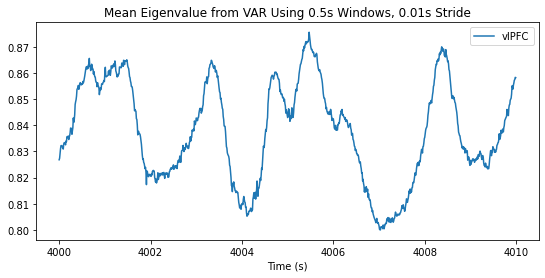

In [35]:
plt.figure(figsize=(9, 4))
start = 4000 # s
end = 4010 # s

start = int(start/stride)
end = int(end/stride)

for area in eigs.keys():
    plt.plot((np.arange(eigs[area].shape[0])*stride)[start:end], eigs[area].mean(1)[start:end], label=area)
plt.title(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

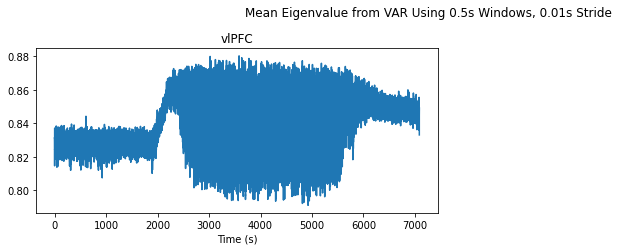

In [28]:
start = 20
end = -30
plt.figure(figsize=(12, 6))
for i, area in enumerate(eigs.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot((np.arange(eigs[area].shape[0])*stride)[start:end], eigs[area].mean(1)[start:end], label=area, c=f"C{i}")
    plt.xlabel("Time (s)")
    plt.title(area)
plt.suptitle(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
# plt.legend()
plt.tight_layout()
plt.show()

# Load and Compare to Up States and Down States

In [5]:
window = 0.5 # s
stride = 0.01 # s 
eigs = load(f"../../__data__/eigs_vlPFC_window_{window}_stride_{stride}")

In [73]:
up_down_dict = get_up_down(area_spike_dict)

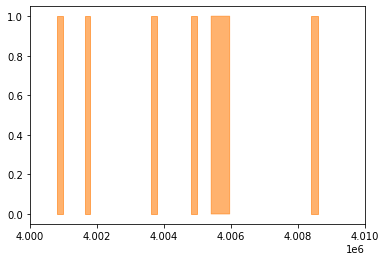

In [84]:

plt.xlim([4000000, 4010000])
plt.show()

In [79]:
area = 'vlPFC'

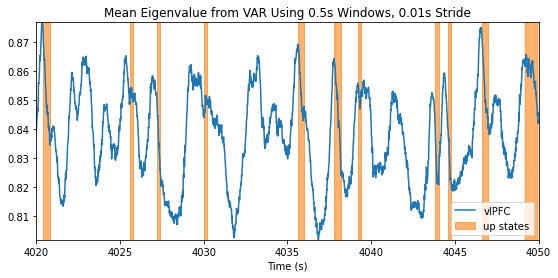

In [233]:
plt.figure(figsize=(9, 4))
def correct_ylim(ax, x, y):   
    # ax: axes object handle
    #  x: data for entire x-axes
    #  y: data for entire y-axes
    # assumption: you have already set the x-limit as desired
    lims = ax.get_xlim()
    i = np.where( (x > lims[0]) &  (x < lims[1]) )[0]
    ax.set_ylim( y[i].min(), y[i].max() ) 

start = 4020 # s
end = 4050 # s

ax = plt.gca()
for area in eigs.keys():
    x = np.arange(eigs[area].shape[0])*stride
    y = eigs[area].mean(1)
    ax.plot(x, y, label=area)
    ax.fill_between(np.arange(len(up_down_dict[area]))*dt, 0, 1, where=up_down_dict[area], color='C1', alpha=0.6, label='up states')
    ax.set_xlim([start, end])
    correct_ylim(ax, x, y)
ax.autoscale_view()
plt.title(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

In [209]:
area = 'vlPFC'
deep_drug_start, deep_drug_end = session_info['drugStart'][1], session_info['drugEnd'][1]
eigs_time_vals = np.arange(eigs[area].shape[0])*stride
deep_drug_eig_bool = np.logical_and(eigs_time_vals > deep_drug_start, eigs_time_vals < deep_drug_end)
deep_drug_eigs = eigs[area][deep_drug_eig_bool]
deep_drug_eigs_time_vals = eigs_time_vals[deep_drug_eig_bool]

In [210]:
def contiguous_segments(array):
    idx = 0
    res = defaultdict(list)

    # grouping Consecutives
    for key, sub in groupby(array):
        ele = len(list(sub))

        # append strt index, and till index
        res[key].append((idx, idx + ele - 1))
        idx += ele

    return dict(res)

In [230]:
up_down_dict[area]
up_down_time_vals = np.arange(len(up_down_dict[area]))*dt
deep_drug_up_down_bool = np.logical_and(up_down_time_vals > deep_drug_start, up_down_time_vals < deep_drug_end)
deep_drug_up_down = up_down_dict[area][deep_drug_up_down_bool]
deep_drug_up_down_time_vals = up_down_time_vals[deep_drug_up_down_bool]

up_down_state_segments = contiguous_segments(deep_drug_up_down)
up_state_eig_bool = [False]*len(deep_drug_eigs_time_vals)
up_state_segments = np.array(up_down_state_segments[1])*dt + deep_drug_start
for segment in up_state_segments:
    segment_eig_bool = np.logical_and(deep_drug_eigs_time_vals > segment[0], deep_drug_eigs_time_vals < segment[1])
    up_state_eig_bool = np.logical_or(up_state_eig_bool, segment_eig_bool)

up_state_eigs = deep_drug_eigs[up_state_eig_bool]
down_state_eigs = deep_drug_eigs[~up_state_eig_bool]

print(f"Average up state eigenvalue (deep drug phase): {up_state_eigs.mean():.2f} +/- {up_state_eigs.std():.2f}")
print(f"Average down state eigenvalue (deep drug phase): {down_state_eigs.mean():.2f} +/- {down_state_eigs.std():.2f}")

Average up state eigenvalue (deep drug phase): 0.85 +/- 0.10
Average down state eigenvalue (deep drug phase): 0.84 +/- 0.10


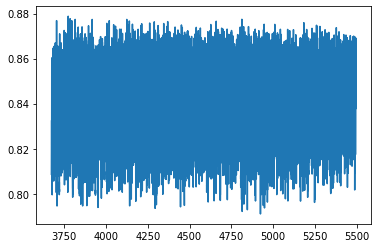

In [123]:
plt.plot(deep_anesthesia_eigs_time_vals, deep_anesthesia_eigs.mean(1))